# Data from the Copenhagen Networks Study

The data here comes from the Copenhagen Networks Study. 

- [Data download](https://figshare.com/articles/dataset/The_Copenhagen_Networks_Study_interaction_data/7267433/1)
- [Data overview](https://www.nature.com/articles/s41597-019-0325-x.pdf)

In [48]:
import pandas as pd
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from dcss.plotting import custom_seaborn
custom_seaborn()
from collections import Counter

In [3]:
from dcss.paths import copenhagen_networks_path
bluetooth_contact = pd.read_csv(copenhagen_networks_path / "bt_symmetric.csv", sep=',')
phone_calls = pd.read_csv(copenhagen_networks_path / "calls.csv", sep=',') 
sms_messages = pd.read_csv(copenhagen_networks_path / "sms.csv", sep=',') 
facebook_friendship = pd.read_csv(copenhagen_networks_path / "fb_friends.csv", sep=',') 

## Bluetooth Contact Networks

The bluetooth contact network data contains 4 variables:

- `timestamp`:
- `user A`:
- `user B`:
- `received signal strength (RSSI)`:

Key information about data collection:

- Each participants phone scanned to detect with devices within 10m/30ft every five minutes
- Each participants phone is always discoverable on Bluetooth 
- RSSI is a proxy for physical distance, with higher measures indicating close proximity and lower measures indicating that the phones were greater distances apart
- "Empty scans are marked with user B = -1 and RSSI = 0"
- "Scans of devices outside of the experiment are marked with user B = -2. All non-experiment devices are given the same ID."

In [12]:
bluetooth_contact.head()

,# timestamp,user_a,user_b,rssi
0,0,0,-1,0
1,0,1,-1,0
2,0,2,-1,0
3,0,3,-2,-88
4,0,5,-1,0


In [13]:
bluetooth_contact.sample(5)

,# timestamp,user_a,user_b,rssi
1034977,484500,368,-1,0
465304,224100,306,16,-62
1466027,725700,665,563,-85
171773,108300,532,51,-82
1374377,679500,252,-1,0


The timestamps are a bit weird. Disregard all that start with 0 for sure. After that they jump up to 300 and seem to change their increments at some points. Suspect this is due to privacy measures?

In [54]:
def get_sequential_timestamps(dataframe, timestamp, n_timestamps, timestamp_var='# timestamp'):
    """
    Helper function for `get_timeframe()`
    
    Takes in a dataframe. Gets a list of the unique timestamps in the order they
    appear in the data. Takes a specified timestep and the number of timesteps 
    to collect folling that one. Returns a sequence of timestamps as a list that
    can be fed directly into the `get_timeframe()` function to return a 
    properly subsetted dataframe.
    """
    ordered_timestamps = list(dataframe[timestamp_var].unique())
    start = ordered_timestamps.index(timestamp)
    end = start + n_timestamps
    selected = ordered_timestamps[start:end]
    return selected

def get_timeframe(dataframe, timestamp, n_timestamps=1, timestamp_var='# timestamp'):
    """
    It takes in the bluetooth dataframe as the first argument and a specific timestamp.
    If that's all that's provided, then it will return all the edges for that timestamp
    with the null scans (marked with negative scores for user_b) screened out.
    
    If n_timestamps is provided, it will return all the data for that many sequential 
    unique timestamps. 
    """
    timeframe = get_sequential_timestamps(dataframe, timestamp, n_timestamps, timestamp_var=timestamp_var)
    df = dataframe[(dataframe['# timestamp'].isin(timeframe)) & (dataframe['user_b'] >= 0)] # screen out lonely scans
    return df

In [55]:
bluetooth_contact['# timestamp'].sample(10)

4485160    1974300
2562161    1111800
343683      171900
418859      210000
1148481     550500
2555934    1109100
241892      132900
4453045    1957800
1749210     823200
3694895    1605000
Name: # timestamp, dtype: int64

In [56]:
max(bluetooth_contact['rssi'])

20

In [61]:
filtered = get_timeframe(bluetooth_contact, 1217400, 4032)  # 300 was old start, 288 was old number of steps
# 2016 is roughly equivalent to a week 

# 1429500 and 144 was the other optipon.
# 300 was first pass and was good.
# 1429500 was selected randomly, just because its not 
# the EXACT START of the study (at least as released)
filtered.head()

,# timestamp,user_a,user_b,rssi
2758371,1217400,21,20,-71
2758391,1217400,49,48,-64
2758394,1217400,55,52,-57
2758397,1217400,58,37,-58
2758405,1217400,69,58,-90


In [62]:
filtered = filtered[filtered['rssi'] > -60]

In [63]:
filtered.to_csv('cns_bluetooth_filtered.csv', index=False)

In [64]:
g_bluetooth_contact = nx.from_pandas_edgelist(filtered, 'user_a', 'user_b', create_using=nx.Graph())
g_bluetooth_contact.name = 'CNS Bluetooth Contact'
print(nx.info(g_bluetooth_contact))

Name: CNS Bluetooth Contact
Type: Graph
Number of nodes: 621
Number of edges: 2942
Average degree:   9.4750


In [65]:
layout = nx.nx_pydot.graphviz_layout(g_bluetooth_contact)

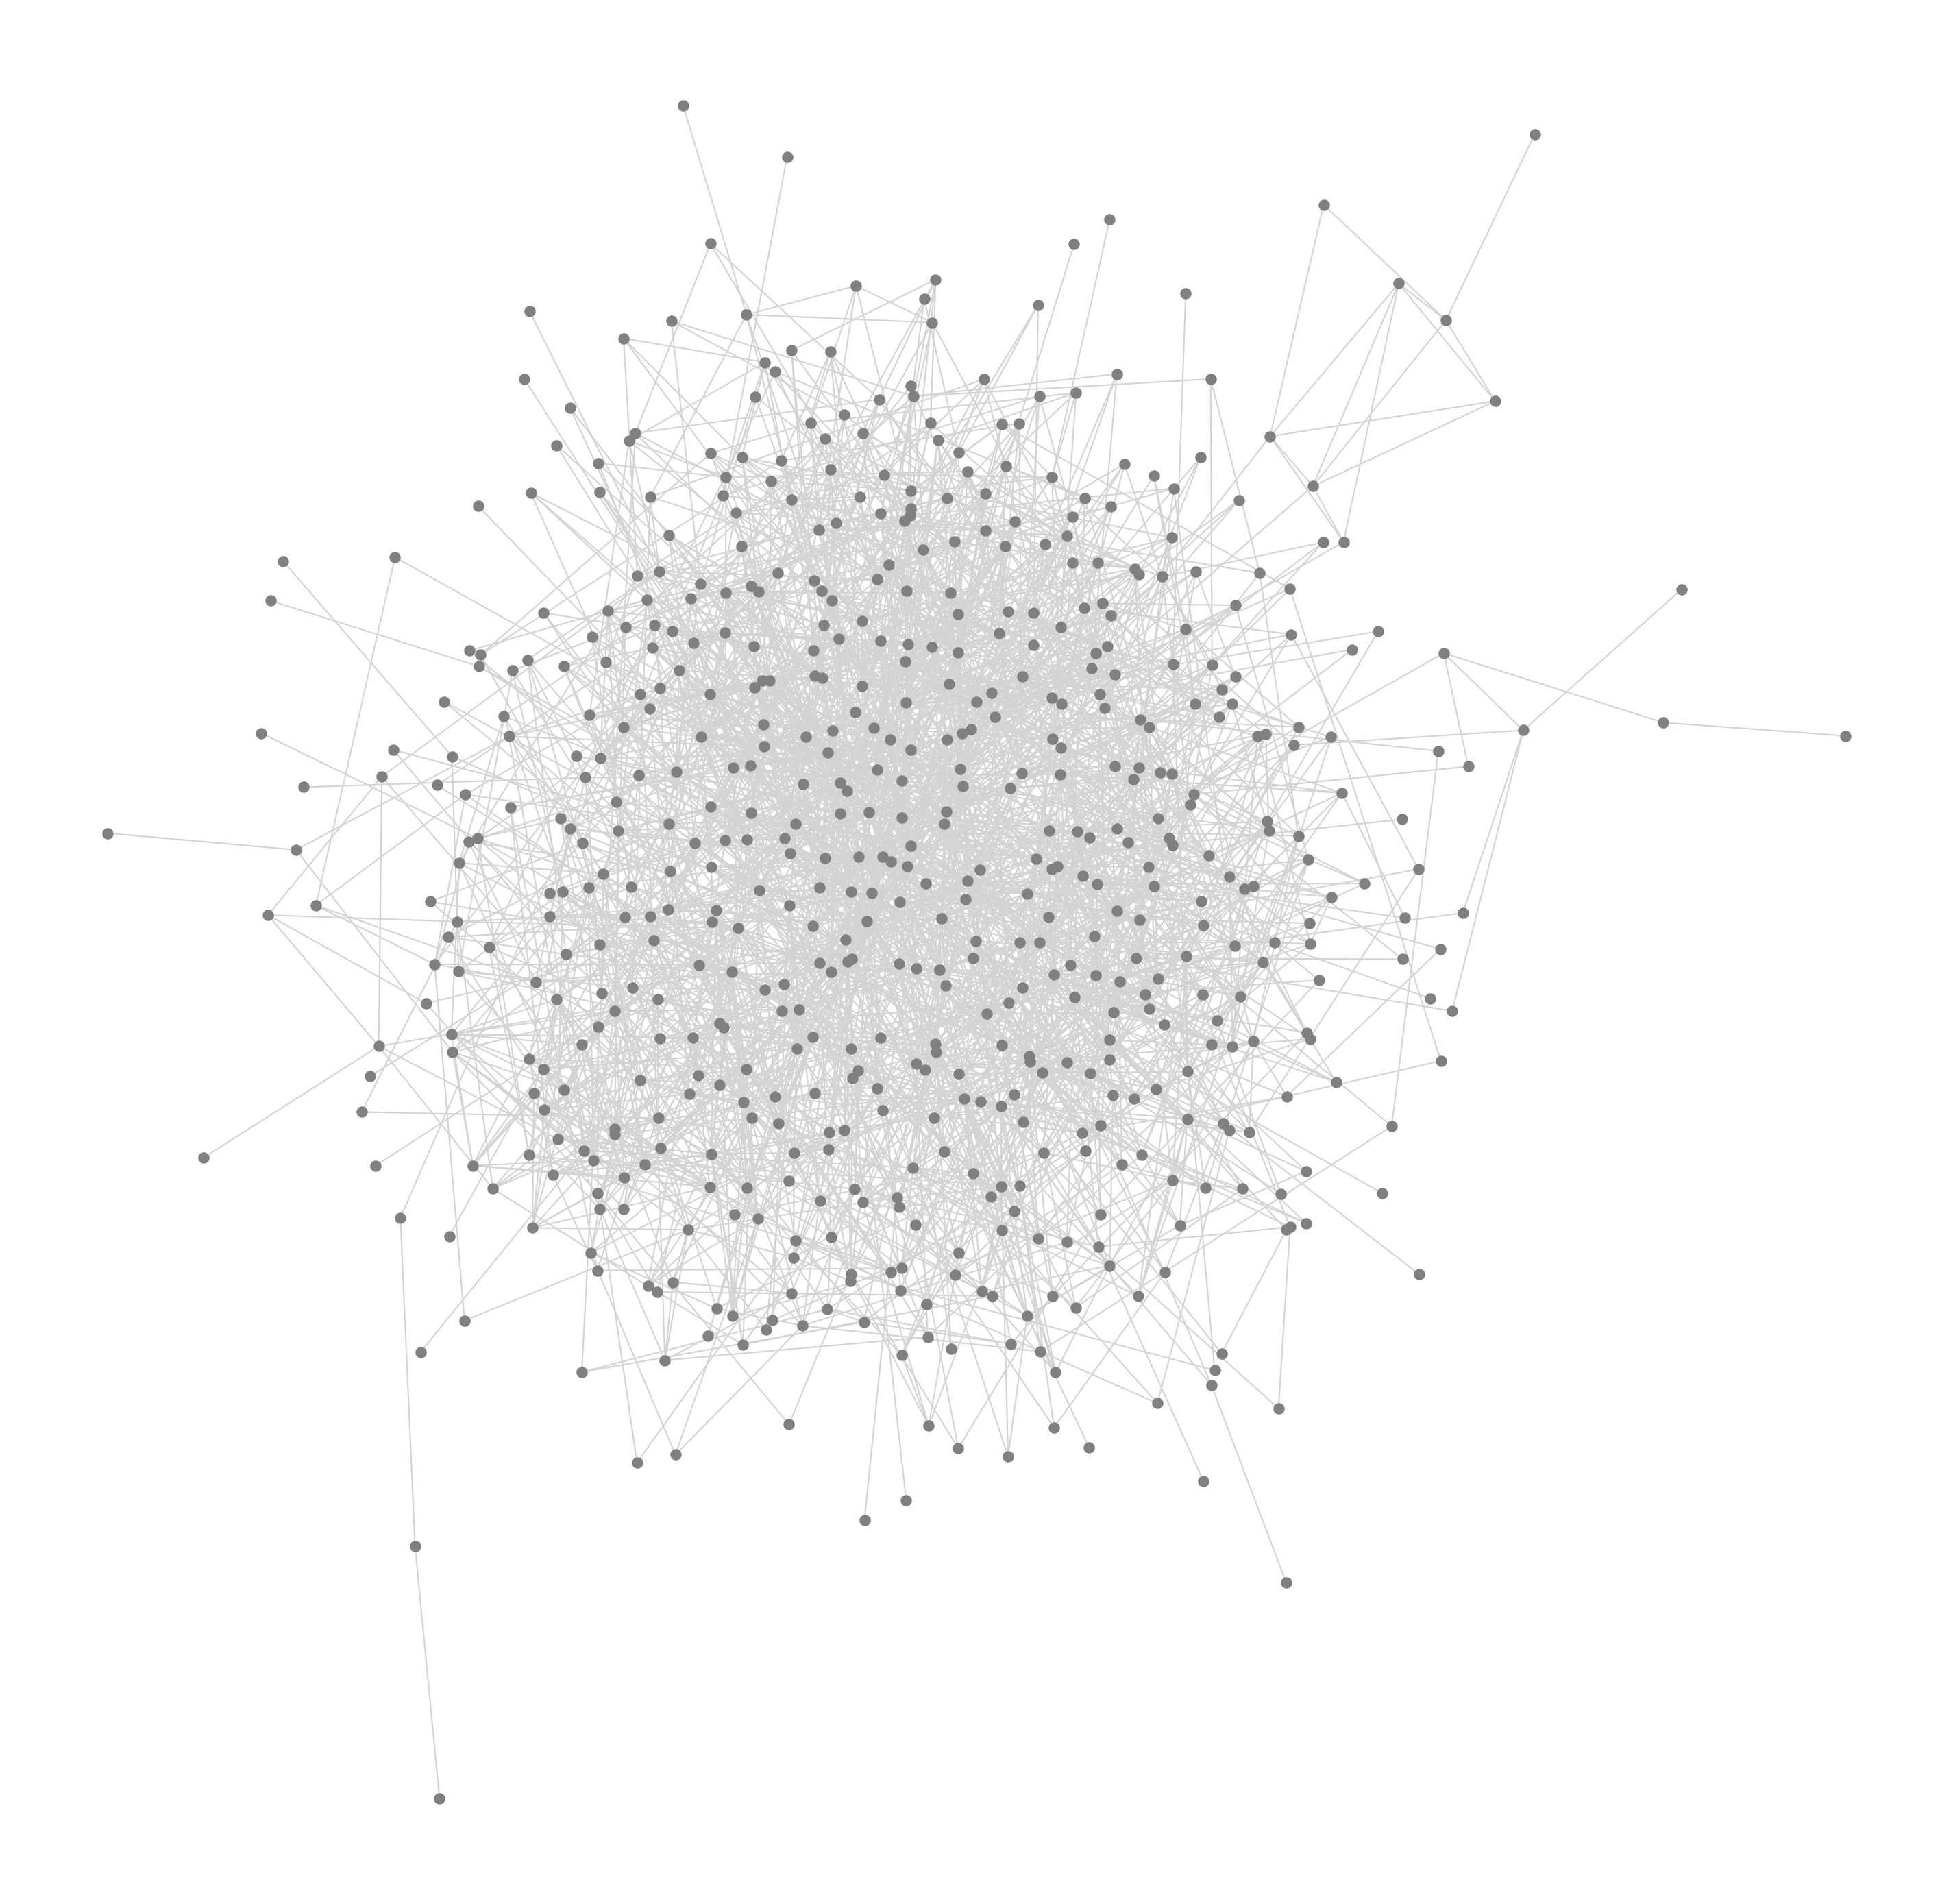

In [66]:
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw(g_bluetooth_contact,
        pos=layout,
        node_color='gray',
        edge_color='lightgray',
        node_size=10,
        width=.5)
plt.show()

## Phone Calls

In [11]:
phone_calls.head()

,timestamp,caller,callee,duration
0,184,300,301,121
1,3920,512,299,670
2,5623,301,300,504
3,9252,401,457,-1
4,15466,512,0,5


## SMS Messages

In [4]:
sms_messages.head()

,timestamp,sender,recipient
0,18,370,512
1,37,512,370
2,126,370,512
3,134,0,512
4,312,137,136


# COMMUNICATION NETWORKS

- Phone calls and SMS messages combined

In [79]:
calls = phone_calls[['caller', 'callee', 'timestamp']]
messages = sms_messages[['sender', 'recipient', 'timestamp']]

In [80]:
messages.columns = ['i', 'j', 'timestamp']
calls.columns = ['i', 'j', 'timestamp']

In [81]:
communication = pd.concat([messages,calls])

In [82]:
communication.head()

,i,j,timestamp
0,370,512,18
1,512,370,37
2,370,512,126
3,0,512,134
4,137,136,312


The code below groups the pairs and counts them up to get an edge weight. Crucially the order of `i` and `j` doesn't matter when we do things this way, so the edge weights are actually correct. 

In [83]:
edges = list(communication[['i', 'j']].to_records(index=False))
weighted_edges = Counter(tuple(sorted(tup)) for tup in edges)
len(weighted_edges)

880

In [84]:
counter_as_tuples = weighted_edges.most_common(len(weighted_edges)) 

In [85]:
G = nx.Graph()

In [86]:
for_networkx = [(we[0][0], we[0][1], we[1]) for we in counter_as_tuples]

In [99]:
with open('cns_weighted_communication_network.csv', 'w') as f:
    f.write('i,j,weight\n')
    for edge in for_networkx:
        f.write(f'{edge[0]},{edge[1]},{edge[2]}\n')

In [87]:
G.add_weighted_edges_from(for_networkx)

In [88]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 608
Number of edges: 880
Average degree:   2.8947


In [92]:
layout = nx.nx_pydot.graphviz_layout(G)

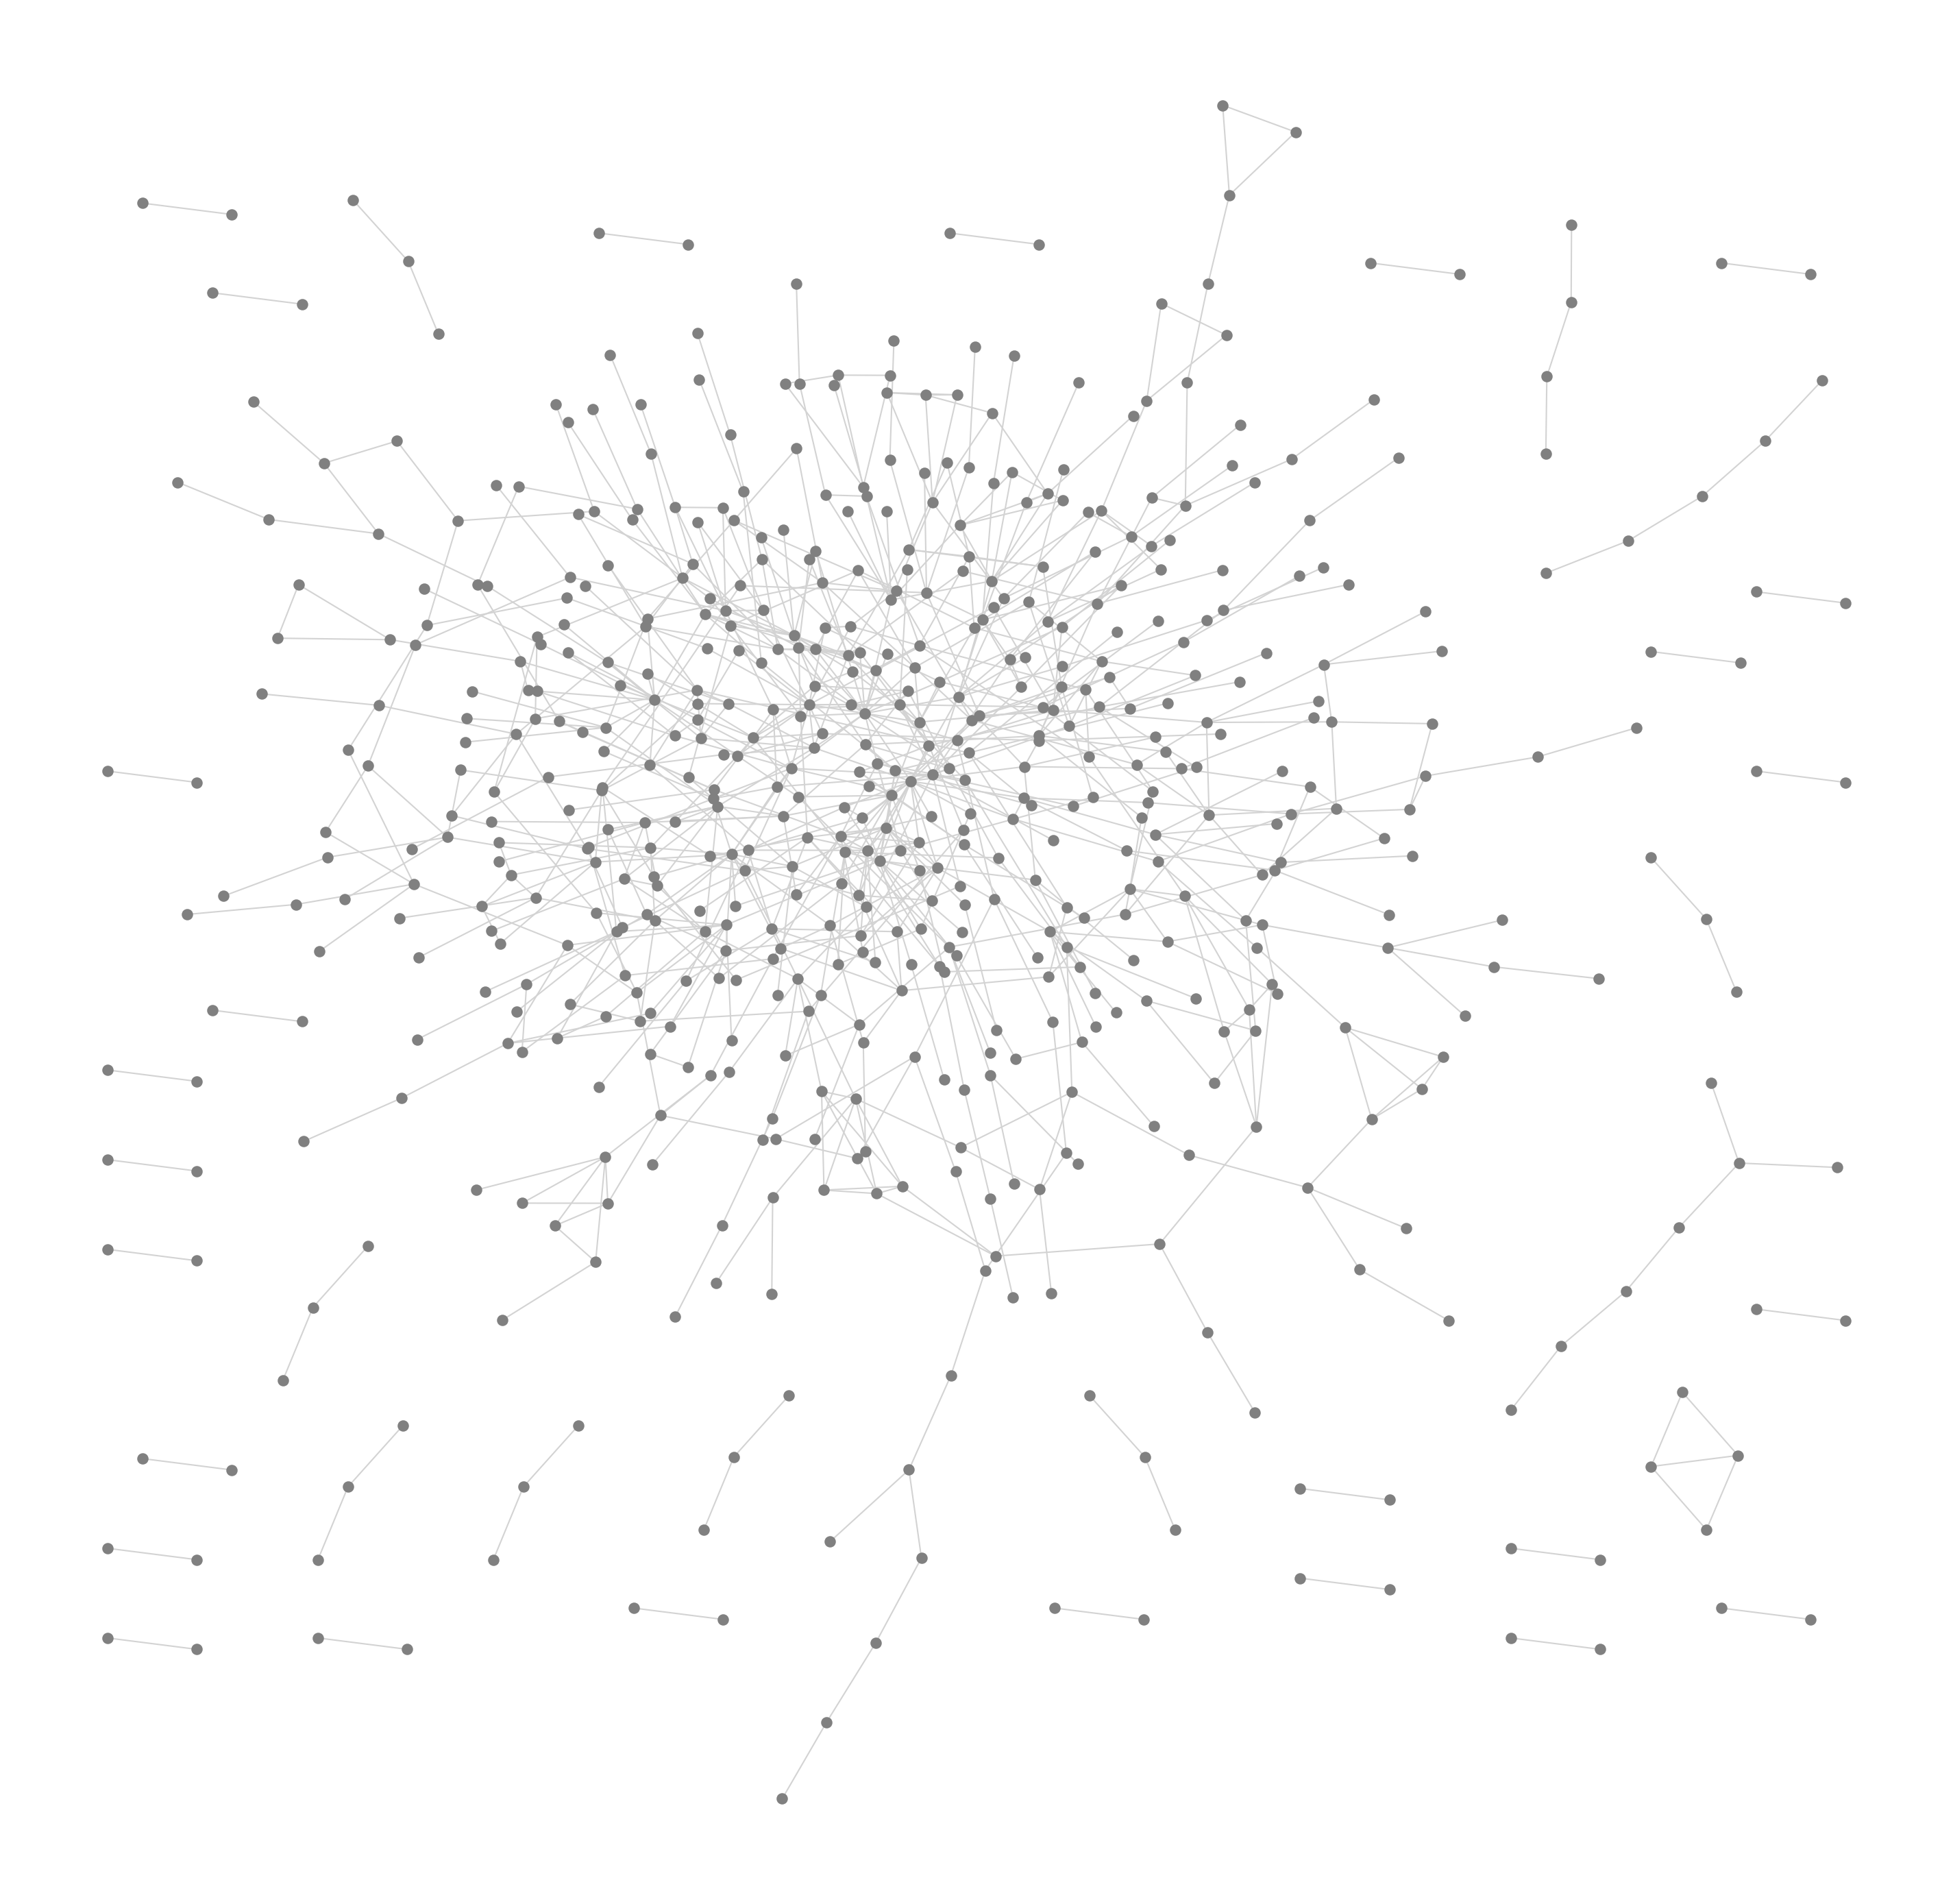

In [93]:
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw(G,
        pos=layout,
        node_color='gray',
        edge_color='lightgray',
        node_size=10,
        width=.5)
plt.show()

In [94]:
[e for e in G.edges(data=True)]

[(279, 617, {'weight': 2866}),
 (617, 391, {'weight': 282}),
 (617, 368, {'weight': 31}),
 (176, 578, {'weight': 1784}),
 (176, 141, {'weight': 193}),
 (176, 611, {'weight': 37}),
 (176, 146, {'weight': 35}),
 (176, 137, {'weight': 20}),
 (176, 236, {'weight': 8}),
 (176, 401, {'weight': 7}),
 (176, 4, {'weight': 5}),
 (176, 486, {'weight': 2}),
 (176, 797, {'weight': 2}),
 (176, 378, {'weight': 1}),
 (176, 263, {'weight': 1}),
 (578, 289, {'weight': 388}),
 (578, 151, {'weight': 96}),
 (578, 97, {'weight': 29}),
 (578, 641, {'weight': 14}),
 (578, 141, {'weight': 12}),
 (578, 371, {'weight': 6}),
 (20, 21, {'weight': 875}),
 (20, 442, {'weight': 22}),
 (296, 481, {'weight': 864}),
 (481, 93, {'weight': 452}),
 (481, 388, {'weight': 38}),
 (481, 706, {'weight': 3}),
 (90, 91, {'weight': 843}),
 (90, 358, {'weight': 41}),
 (90, 472, {'weight': 20}),
 (90, 474, {'weight': 20}),
 (90, 64, {'weight': 4}),
 (90, 485, {'weight': 4}),
 (91, 64, {'weight': 22}),
 (91, 649, {'weight': 6}),
 (13

## Facebook Friends

In [13]:
facebook_friendship.head()

,# user_a,user_b
0,0,512
1,0,263
2,0,525
3,0,285
4,0,543
